# Table of Contents

* [System Design (Part 2)](#System-Design)
  * [cadCAD Standard Notebook Layout](#cadCAD-Standard-Notebook-Layout)
    0. [Dependencies](#0.-Dependencies)
    1. [State Variables](#1.-State-Variables)
    2. [System Parameters](#2.-System-Parameters)
    3. [Policy Functions](#3.-Policy-Functions)
    4. [State Update Functions](#4.-State-Update-Functions)
    5. [Partial State Update Blocks](#5.-Partial-State-Update-Blocks)
    6. [Configuration](#6.-Configuration)
    7. [Execution](#7.-Execution)
    8. [Simulation Output Preparation](#8.-Simulation-Output-Preparation)
    9. [Simulation Analysis](#9.-Simulation-Analysis)

<!--
* [Toy Model Introduction](#Toy-Model-Introduction:-An-Ecosystem-Model)
  * [Some Context: Lotka & Volterra](#Some-Context:-Lotka-&-Volterra)
  * [Visual System Mapping: Entity Relationship Diagram](#Visual-System-Mapping:-Entity-Relationship-Diagram)
  * [Requirements Analysis](#Requirements-Analysis)
  * [Mathematical Specification](#Mathematical-Specification)
  * [Visual System Mapping: Stock & Flow Diagram](#Visual-System-Mapping:-Stock-&-Flow-Diagram)
  * [Differential Specification](#Differential-Specification)
* [cadCAD Standard Notebook Layout](#cadCAD-Standard-Notebook-Layout)
    0. [Dependencies](#0.-Dependencies)
    1. [State Variables](#1.-State-Variables)
    2. [System Parameters](#2.-System-Parameters)
    3. [Policy Functions](#3.-Policy-Functions)
    4. [State Update Functions](#4.-State-Update-Functions)
    5. [Partial State Update Blocks](#5.-Partial-State-Update-Blocks)
    6. [Configuration](#6.-Configuration)
    7. [Execution](#7.-Execution)
    8. [Simulation Output Preparation](#8.-Simulation-Output-Preparation)
    9. [Simulation Analysis](#9.-Simulation-Analysis)
-->

---

Wenn gewünscht, kann dieses partial_state_update_block genommen werden, was die Zustände in einem timestep sequenziell abläuft. Erhöht jedoch die Rechenintensität enorm (Faktor 3).

# 0. Dependencies

In [1]:
# Standard libraries: https://docs.python.org/3/library/
import math

# Analysis and plotting modules
import pandas as pd

# import plotly
import plotly

# import numpy
import numpy as np

# import random
import random 

#import random from nupmy as rdm
from numpy import random as rdm

In [2]:
# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

# 0.01 Monte Carlo Einstellung

In [3]:
# Definition der Anzahl der Monte-Carlo-Runs, damit bei neustart die gliechen random Zahlen durchlaufen, was die Reproduzierbarkeit gewährleistet
Monte_Carlo_Runs = 3

# Festlegen der festen Seeds basierend auf der Anzahl der Runs
fixed_seeds = list(range(1, Monte_Carlo_Runs + 1))

# Initialisieren der Zufallsgeneratoren mit den festen Seeds
rngs = [np.random.default_rng(seed) for seed in fixed_seeds]

# 0.02 Definition der Tage, die Simuliert werden

In [4]:
SIMULATION_TIMESTEPS = 370

# 0.1 Berechnung der Durchschnittlichen ETh pro Staker

In [3]:
# Definiere hier die AuM und Anzahl der Staker aus der folgenden Quelle:
# https://www.stakingrewards.com/provider/blockscape?category=all&sort=staked_tokens&timeframe=30d&byChange=false&order=desc
# Stand 4 Juli

stakewise_eth = 374


#AuM = 1040000000
AuM = 997200000
initial_staker_anzahl = 15510
ETH_Preis = 3163.33
# Prozentsatz davon in ETH (Aus den Lido und Swell Operatoren)
# ETH-Token sind es 280k+22K =302000 Tokens
# oder in Dollar sind es:
ETH_Dollar = 883000000 + 68000000 
# ETH_Dollar = 300632561
print("Blockscape verwaltet in Lido und Swell zum 4. Juli rund " + str(ETH_Dollar) + " Dollar in ETH")
Prozent = (ETH_Dollar/AuM)*100
anzahl_ETH = (AuM/ETH_Preis)*(Prozent/100)
print("Das sind dann: " + str(anzahl_ETH) + "ETH")
average_stake_per_staker = anzahl_ETH/initial_staker_anzahl
print("im Durchschnitt hat ein Staker ca. " + str(average_stake_per_staker) + "an ETH innerhalb von der Blockscape Plattform gestaket")
print("______")
stakewise_staker_anzahl = 100
average_stake_per_staker_stakewise = stakewise_eth/stakewise_staker_anzahl
print("AuM Stakewise: " + str(stakewise_eth*ETH_Preis))
print("Durschnittlicher Stake pro Staker auf Stakewise: " + str(average_stake_per_staker_stakewise))

Blockscape verwaltet in Lido und Swell zum 4. Juli rund 951000000 Dollar in ETH
Das sind dann: 300632.5612566504ETH
im Durchschnitt hat ein Staker ca. 19.383143859229556an ETH innerhalb von der Blockscape Plattform gestaket
______
AuM Stakewise: 1183085.42
Durschnittlicher Stake pro Staker auf Stakewise: 3.74


# 0.2 Berechnung des Anteils am Ethereum Netzwerks

In [6]:
# infos von:https://www.coinbase.com/de/earn/staking/ethereum#:~:text=Wie%20viele%20Ethereum%2DToken%20werden,Ethereum%20auf%20103%2C4%20Mrd
# Stand 4 Juli
# Anteil Gestakter ETH-Token
anteil_gestakter_eth_token = 27.28 # in Prozent
# Gestakte Tokens an der Zahl
gestakte_token_eth_netzwerk = 32800000 # 32,8 Mio

# Anteil Blockscape am Gesamtnetzwerk
anteil_blockscape = (anzahl_ETH/gestakte_token_eth_netzwerk)*100
print("Blockscapes Anteil am Staking-Gesamtnetzwerk von ETH beträgt rund " + str(anteil_blockscape) + "%")

Blockscapes Anteil am Staking-Gesamtnetzwerk von ETH beträgt rund 0.9165626867580805%


# 0.3 Berechnung Mitarbeiter kosten + zusätzliche Konfiguration über Ausgaben für die Kostengegenüberstellung

In [7]:
# Funktion zur Berechnung der Ausgaben
def new_cost_MA(MA_Anzahl, MA_kosten, KV, RV, AV, PV):
    if isinstance(KV, dict):
        KV = KV.get('value', 0)
    if isinstance(RV, dict):
        RV = RV.get('value', 0)
    if isinstance(AV, dict):
        AV = AV.get('value', 0)
    if isinstance(PV, dict):
        PV = PV.get('value', 0)
    
    value_KV = MA_kosten * KV
    value_RV = MA_kosten * RV
    value_AV = MA_kosten * AV
    value_PV = MA_kosten * PV
    cost_MA = MA_kosten + value_KV + value_RV + value_AV + value_PV
    total_cost_MA = cost_MA * MA_Anzahl
    return total_cost_MA


def calculate_stETH(staker_count, average_stake_per_staker):
    return staker_count * average_stake_per_staker

In [8]:
KV = 0.086
RV = 0.093
AV = 0.013
PV = 0.01525
ma_kosten = 50000  # Durschnittliche Mitarbeiter Kosten
initial_ma_anzahl = 9  # Mitarbeiter Anzahl
initial_ma_kosten = new_cost_MA(1, ma_kosten, KV, RV, AV, PV)
initial_ma_kosten

60362.5

In [9]:
# Berechnung der initialen Werte
initial_stETH = calculate_stETH(initial_staker_anzahl, average_stake_per_staker)  # number of staked Eth in Blockscape
initial_APY = 0.03  # Annual Percentage Yield (Ethereum)
initial_PR = 0.05  # Provision Rate for Blockscape
validators_je_server = 1000  # Anzahl der Validator, die auf einem Server laufen können
initialer_server_preis = 700

# Initiale Berechnungen
initial_validator_anzahl = math.ceil(initial_stETH / 32)
initial_server_anzahl = math.ceil(initial_validator_anzahl / validators_je_server)
initiale_infra_kosten = initial_server_anzahl * initialer_server_preis

# 0.4 Rückerstattungsfunktion
> Siehe unter Visuelle_Repräsentation_der_Rückerstattungsfunktion.ipynb für mehr infos

In [10]:
# Rückerstattungsfunktion 
#def R(t, s, alpha=0.0004009):
#    return 1 - np.exp(-alpha * np.sqrt(t) * np.sqrt(s))

#Rückerstattungsfunktion optimiert
def R(t, s, APY, PR):
    exp_part = np.exp(-APY * np.sqrt(t) * np.sqrt(s * PR * APY))
    if exp_part > 0.8:
        return 0
    else:
        return 0.8 - exp_part

# Funktion zur Kalkulation der Rückerstattungsrate, in Abhängigkeit der BLCS Token und staked ETH
def calculate_refund_rate(blcs_tokens, staked_eth, apy, pr):
    return R(blcs_tokens, staked_eth, apy, pr)

def calculate_commission(staked_eth, apy, pr):
    return staked_eth * apy * pr
    
def calculate_commission_after_refund(commission, refund_rate):
    return commission * (1-refund_rate)
    
# Funktion zur Berechnung der Kommission
def s_calculate_commission_after_refund(params, substep, state_history, previous_state, policy_input):
    apy = system_params['APY'][0]
    pr = previous_state['PR']
    stakers = previous_state['Stakers']
    total_commission = 0
    
    for staker in stakers:
        staked_eth = staker['staked_eth']
        blcs_tokens = staker['blcs_tokens']
        refund_rate = calculate_refund_rate(blcs_tokens, staked_eth, apy, pr)
        staker['Refund_Rate'] = refund_rate
        commission = calculate_commission(staked_eth, apy, pr)
        commision_after_refund = calculate_commission_after_refund(commission, refund_rate)
        commision_day = commision_after_refund / 365
        total_commission += commision_day

    return 'Gesamte Kommission Nach Refund', total_commission

def s_calculate_refund(params, substep, state_history, previous_state, policy_input):
    apy = system_params['APY'][0]
    pr = previous_state['PR']
    stakers = previous_state['Stakers']
    old_refund_value = previous_state['Refund']
    token_price = previous_state['Token_Price']
    eth_price = previous_state['ETH_Preis']
    total_refund_blcs_staker_in_eth = 0
    timestep = previous_state['timestep']
    
    if timestep < 5:
        return 'Refund', 0
    
    apy = system_params['APY'][0]
    pr = previous_state['PR']
    stakers = previous_state['Stakers']
    old_refund_value = previous_state['Refund']
    token_price = previous_state['Token_Price']
    eth_price = previous_state['ETH_Preis']
    total_refund_blcs_staker = 0
    
    for staker in stakers:
        staked_eth = staker['staked_eth']
        blcs_tokens = staker['blcs_tokens']
        refund_rate = calculate_refund_rate(blcs_tokens, staked_eth, apy, pr)
        staker['Refund_Rate'] = refund_rate
        commission = calculate_commission(staked_eth, apy, pr)
        commision_after_refund = calculate_commission_after_refund(commission, refund_rate)
        refund_value = commission - commision_after_refund
        refund_value_day = refund_value / 365
        staker_refund_blcs = refund_value_day / token_price * eth_price
        staker['blcs_tokens'] += staker_refund_blcs
        total_refund_blcs_staker += staker_refund_blcs

    new_value_refund_blcs = old_refund_value + total_refund_blcs_staker
    
    return 'Refund', new_value_refund_blcs

# Beispiel zur Nutzung der Funktion
staked_eth = 40
apy = 0.03 
pr = 0.05 
blcs_tokens = 10000

refund_rate = calculate_refund_rate(blcs_tokens, staked_eth, apy, pr)
commission = calculate_commission(staked_eth, apy, pr)
print("refund_rate:", refund_rate)
print("Kommission in % (Die Blockscape noch weiterhin erhählt):", (1-refund_rate)*100)
print("Kommissionswert mit Refund (theoretisch):", commission)
Returnwert = (commission - (calculate_commission_after_refund(commission,refund_rate)))
print("Refund Wert:", Returnwert)
print("Kommission in Euro (im Jahr):", commission*ETH_Preis )
print("Returnwert in Euro (im Jahr):", Returnwert*ETH_Preis )
print("Diff in Euro (im Jahr):", commission*ETH_Preis-Returnwert*ETH_Preis)

refund_rate: 0.3204211340705008
Kommission in % (Die Blockscape noch weiterhin erhählt): 67.95788659294992
Kommissionswert mit Refund (theoretisch): 0.06
Refund Wert: 0.019225268044230047
Kommission in Euro (im Jahr): 189.79979999999998
Returnwert in Euro (im Jahr): 60.81586716235423
Diff in Euro (im Jahr): 128.98393283764574


In [11]:
# Hilfsfunktion zur Berechnung der neuen stETH, die durch die APY pro Tag dazukommen
def add_stETH_amount(current_stETH_amount, APY):
    return current_stETH_amount*APY/365

# Funktion zur Berechnung der neuen stETH Amounts 
def new_stETH_amount(current_stETH_amount, add_amount):
    return current_stETH_amount + add_amount

# Hilfsfunktion zur Berechnung der neuen Einnahmen für Blockscape, die durch die Provisionsrate bestimmt wird
def add_revenue_amount(reward_stETH_amount, APY, PR):
    return reward_stETH_amount*PR

# Funktion zur Berechnung des neuen Revenue-Wertes
def new_revenue_amount(revenue_amount, add_rev_amount):
    return revenue_amount+add_rev_amount

# Konvertierungsfunktion
def convert_to_ETH(value, eth_faktor):
    return value/eth_faktor

def convert_to_euro(value, euro_faktor):
    return value+eth_faktor

# Funktion zur Bestimmung der Anzahl der Validatoren
def new_amount_validators(stEth):
    return math.ceil(stEth/32)

# Funktion zur Bestimmung der Anzahl der Server
def new_amount_servers(current_amount_validators, faktor):
    return math.ceil(current_amount_validators/faktor)

# Funktion zur BErechnung der Infrastrukturkosten
def calculate_infrastructure_costs(server_count, server_price):
    return server_count * server_price

#Funktion zur Berechnung der Mitarbeiterkosten
def calculate_employee_costs(employee_count, employee_cost):
    return employee_count * employee_cost

# Funkntion zur jährlichen Erhöhung der Mitarbeiteranzahl
def increase_employee_count(employee_count, year):
    if year % 365 == 0:  # Annahme: Ein Jahr hat 365 Tage
        return employee_count + 1
    return employee_count


# Hilfsfunktion zur Berechnung der Rewards für jeden einzelnen staker
def calculate_rewards_for_stakers(stakers, apy):
    for staker in stakers:
        staked_eth = staker['staked_eth']
        rewards = staked_eth * apy/365
        staker['rewards'] = rewards
        staker['rewards_total'] += rewards
    return stakers

# 0.6 Randomisierte Initialisierung der Stakers

In [12]:
def initialize_stakers(anzahl_eth, num_stakers, rng, run_id, timestep):
    # Berechnung des durchschnittlichen Stakes pro Staker
    average_stake_per_staker = anzahl_eth / num_stakers
    
    stakers = []
    print("Werte:", anzahl_eth, num_stakers, run_id)

    if timestep == 0:
        # Initialisierung des "Airdrop" der gültigen Adressen, die verifizieren können, dass sie stake bei Blockscape haben
        total_blcs_airdrop = 50000000

        for i in range(num_stakers):
            # Variation des staked_eth_balance basierend auf run_id
            if run_id == 0:  # kleiner spread
                staked_eth_balance = rng.uniform(average_stake_per_staker * 0.5, average_stake_per_staker * 1.5)
            elif run_id == 1:  # neutraler spread
                staked_eth_balance = rng.uniform(average_stake_per_staker * 0.25, average_stake_per_staker * 1.75)
            elif run_id == 2:  # großer spread
                #staked_eth_balance = rng.uniform(average_stake_per_staker * 0.1, average_stake_per_staker * 5)
                #staked_eth_balance = rng.triangular(average_stake_per_staker * 0.1, (average_stake_per_staker/5), average_stake_per_staker * 5)
                staked_eth_balance = rng.uniform(average_stake_per_staker * 0.1, average_stake_per_staker * 1.95)
           
            eth_balance = staked_eth_balance * 0.1
            
            # Airdrop Entscheidung (nur 50% der Staker erhalten einen Airdrop)
            receives_airdrop = random.choice([0, 1])

            # Alternative Airdrop Entscheidung (nur 25% der Staker erhalten einen Airdrop)
            # receives_airdrop = random.choice([0, 1, 2, 3])

            # Alternative Airdrop Entscheidung (nur 10% der Staker erhalten einen Airdrop)
            # receives_airdrop = random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

            if receives_airdrop == 1:
                # Airdrop Berechnung mit Faktor von 1 Attraktivität in der Marketingmitteilung
                airdrop_blcs = (total_blcs_airdrop / anzahl_eth) * staked_eth_balance

                # 20% der Airdrop BLCS-Token sind sofort verfügbar, 80% sind unlockable
                blcs_tokens = airdrop_blcs * 0.2
            else:
                airdrop_blcs = 0
                blcs_tokens = 0

            rewards = 0
            rewards_total = 0

            stakers.append({
                'eth': eth_balance,
                'staked_eth': staked_eth_balance,
                'blcs_tokens': blcs_tokens,
                'Refund_Rate': 0,
                'rewards': rewards,
                'rewards_total': rewards_total,
                'airdrop_received': 1 if receives_airdrop == 1 else 0  # Airdrop erhalten (1 oder 0)
            })
    else:
        # Initialisierung neuer Staker
        for _ in range(num_stakers):
            staked_eth_balance = rng.uniform(average_stake_per_staker * 0.75, average_stake_per_staker * 1.25)
            eth_balance = staked_eth_balance * 0.1
            blcs_tokens = 0
            rewards = 0
            rewards_total = 0

            stakers.append({
                'eth': eth_balance,
                'staked_eth': staked_eth_balance,
                'blcs_tokens': blcs_tokens,
                'Refund_Rate': 0,
                'rewards': rewards,
                'rewards_total': rewards_total,
                'airdrop_received': 0  # Neue Staker erhalten keinen Airdrop
            })

    return stakers

# 0.7 Initialisierung des Token Preises und Staker IDO Kuafverhaltenvariable

> Potential hier eine Herleitung zu bauen, die den Token Preis bestimmt
> siehe Notizblock 

In [13]:
initial_token_price = 0.01
IDO_amount = 50000000
ETH_Preis = 3163.33

# Wenn alle Tokens verkauft wurden, wird der AMM_Pool mit der folgenden Anzahl an ETH gefüllt:
amm_amount_eth = IDO_amount * initial_token_price / ETH_Preis
konstante_k = amm_amount_eth * IDO_amount

staker_buy_ido_rate = 0.1
15
print("Initialisierte Werte:")
print(f"Initialer Tokenpreis: {initial_token_price}")
print(f"IDO Menge: {IDO_amount}")
print(f"ETH Preis: {ETH_Preis}")
print(f"Anzahl ETH im AMM: {amm_amount_eth}")
print(f"Konstante K: {konstante_k}")

Initialisierte Werte:
Initialer Tokenpreis: 0.01
IDO Menge: 50000000
ETH Preis: 3163.33
Anzahl ETH im AMM: 158.0612835208467
Konstante K: 7903064176.042335


# 1. State Variables

In [14]:
# Initial State Configuration ohne Staker-Initialisierung
initial_state = {
    'stETH': initial_stETH, 
    'Einnahmen_ETH': 0, 
    'ETH_Preis': ETH_Preis, 
    'Staker_Anzahl': initial_staker_anzahl, 
    'Stakers': [],  # Anzahl Staker auf der Blockscape Plattform
    'Server_Anzahl': initial_server_anzahl, 
    'Validator_Anzahl': initial_validator_anzahl, 
    'Ausgaben': 0, 
    'Server_Preis': initialer_server_preis, 
    'MA_Anzahl': initial_ma_anzahl, 
    '1_MA_Kosten': initial_ma_kosten, 
    'Infra_Kosten': initiale_infra_kosten, 
    'Einnahmen_Euro': 0, 
    # 'Anteil_Netzwerk': anteil_blockscape, 
    'Total_Cost_MA_pro_Jahr': 0, 
    'Refund': 0, 
    'PR': 0.05, 
    'Gesamte Kommission Nach Refund': 0, 

    #'Demand': 100000,   # Startnachfrage nach Tokens
    # Beispielwerte Pool
    'AMM_Pool': {'ETH': amm_amount_eth, 'BLCS': IDO_amount},  # Initialwerte des AMM-Pools
    'Token_Price': initial_token_price,
}

## **Time** as a system state


* 1 **timestep** == 1 Tag

# 2. System Parameters

> System parameterization is the process of choosing variables that impact the behaviour of the model. These parameters allow us to perform simulation techniques like parameter sweeps, Monte Carlo simulations, A/B tests, and see how the system behaves under a different model parameter set.

[Link to Simulation Analysis](#9.-Simulation-Analysis)

In [15]:
system_params = {
    # stETH und Einnahmen Parameter
    'APY': [initial_APY],  # Annual Percentage Yield (Ethereum)
    'PR': [initial_PR],    # Provision Rate for Blockscape
    'Provision_Increase': [0.001], # Provisionzuwachs, wenn zu Niedrieg 
    # Ausgaben Parameter
    'Validators_je_Server': [validators_je_server],  # Anzahl der Validator, die auf einem Server laufen können

    # dynamische Parameter für Staker
    'average_stake_per_staker': [average_stake_per_staker],
    'staker_reproduction_rate': [0.0000001],
    'staker_exit_rate': [0.0001],

    # Nachfrage nach den Token
    'Demand': [0.01],
    
    # zusätzliche Parameter die angepasst werden können (erhöhung Krankenversicherung usw)
    'KV': [0.086],
    'RV': [0.093],
    'AV': [0.013],
    'PV': [0.01525],

    # Parameter für den simulierten AMM
    'Konstante_K': [konstante_k],
    'staker_buy_ido_rate': [staker_buy_ido_rate]
}

# 3. Policy Functions

> A Policy Function computes one or more signals to be passed to State Update Functions. They describe the logic  and behaviour of a system component  or mechanism.
>
> Policy Function sind Funktionen die Auswirkungen auf die system_params haben
> 

In [16]:
def p_adjust_demand(params, substep, state_history, previous_state):
    timestep = previous_state['timestep']
    current_demand = params['Demand']
    current_price = previous_state['Token_Price']

    # Bestimme den Preis des Tages zuvor
    if timestep > 0:
        previous_day_timestep = timestep - 1
        # Suche den Preis des vorherigen Tages in state_history
        price_day_ago = initial_token_price  # Fallback, falls der Preis des Vortags nicht gefunden wird
        for day in state_history:
            for state in day:
                if state['timestep'] == previous_day_timestep:
                    price_day_ago = state['Token_Price']
                    break
            if price_day_ago != initial_token_price:
                break
    else:
        price_day_ago = initial_token_price

    print("price_day_ago", price_day_ago)
    # Preiselastizität der Nachfrage (negativer Wert, da höhere Preise zu niedrigerer Nachfrage führen)
    elasticity = -0.5

    # Berechnung der neuen Nachfrage basierend auf der Preiselastizität, aber nur ab dem fünften Timestep
    if timestep >= 5:
        demand_change = elasticity * ((current_price - price_day_ago) / price_day_ago)
        new_demand = current_demand + demand_change
        new_demand = max(0, min(1, new_demand))  # Begrenzung der Nachfrage auf den Bereich 0 bis 1
        new_demand = round(new_demand, 6)  # Rundung auf 6 Dezimalstellen
        print("demand", new_demand)
    else:
        new_demand = current_demand

    return {'Demand': new_demand}


In [17]:
# Funktionen zum Staker Abgang und Zugang
def p_staker_access(params, substep, state_history, previous_state):
    current_reproduction_rate = params['staker_reproduction_rate']
    available_tokens = previous_state['AMM_Pool']['BLCS']
    
    # Zugangsrate basierend auf den verfügbaren Tokens und der Reproduktionsrate
    staker_access = current_reproduction_rate * available_tokens
    return {'delta_staker_access': staker_access}

def p_staker_exit(params, substep, state_history, previous_state):
    current_exit_rate = params['staker_exit_rate']
    current_population = previous_state['Staker_Anzahl']
    
    # Abgangsrate basierend auf der aktuellen Population
    staker_exit = current_exit_rate * current_population
    return {'delta_staker_exit': -staker_exit}


# 4. State Update Functions

> We create State Update Functions to design the way our model state changes over time. These will usually represent the system differential specification.

# 4.1 Definition von State update Funktionen

In [18]:
# State Update Funktion, um die Änderung des staking Amounts über die Zeit darzustellen
def s_calculate_stETH_amount(params, substep, state_history, previous_state, policy_input):
    stakers = previous_state['Stakers']

    total_staked_eth = sum(staker['staked_eth'] for staker in stakers)  + sum(staker['rewards_total'] for staker in stakers)
    APY = system_params['APY'][0]
    print("total_staked_eth", total_staked_eth)

    # Berechnung der zusätzlichen ETH durch APY
    add_eth_amount = add_stETH_amount(total_staked_eth, APY)
    print("add_eth_amount", add_eth_amount)

    # Hinzufügen der neuen ETH zum vorherigen stETH
    new_eth_amount = total_staked_eth + add_eth_amount
    print("new_eth_amount", new_eth_amount)

    return ('stETH', new_eth_amount)


# State Update Funktion, um die Änderung der Revenue über die Zeit darzustellen
def s_calculate_revenue_amount(params, substep, state_history, previous_state, policy_input):
    stakers = previous_state['Stakers']
    APY = system_params['APY'][0]
    revenue = previous_state['Einnahmen_ETH']
    PR = previous_state['PR']  # Verwende den aktuellen Wert von PR aus dem vorherigen Zustand

    # Berechne die Rewards für jeden Staker
    stakers = calculate_rewards_for_stakers(stakers,APY)

    # Akkumuliere die Rewards aller Staker
    total_rewards = sum(staker['rewards'] for staker in stakers)

    # Berechne den zusätzlichen Revenue basierend auf den Rewards und PR
    add_rev_amount = add_revenue_amount(total_rewards, APY, PR)  # Korrigierte Funktion
    new_rev_amount = new_revenue_amount(revenue, add_rev_amount)

    return 'Einnahmen_ETH', new_rev_amount



# State-Update-Funktion, um die Anzahl der Validatoren zu berechnen
def s_update_vali_count(params, substep, state_history, previous_state, policy_input):
    stETH = previous_state['stETH']
    amount_valis = new_amount_validators(stETH)

    return ('Validator_Anzahl', amount_valis)


# State-Update-Funktion, um die Anzahl der Server zu berechnen
def s_update_server_count(params, substep, state_history, previous_state, policy_input):
    amount_valis = previous_state['Validator_Anzahl']
    faktor = system_params['Validators_je_Server'][0]
    amount_servers = new_amount_servers(amount_valis, faktor)

    return ('Server_Anzahl', amount_servers)

# Funktion zur Berechnung der MA Kosten
def s_calculate_new_employee_count(params, substep, state_history, previous_state, policy_input):
    employee_count = previous_state['MA_Anzahl']
    day = len(state_history)  

    new_employee_count = increase_employee_count(employee_count, day)

    return ('MA_Anzahl', new_employee_count)

# Funktion zur Berechnung der Infra Kosten
def s_calculate_infrastructure_costs(params, substep, state_history, previous_state, policy_input):
    server_count = previous_state['Server_Anzahl']
    server_price = previous_state['Server_Preis']

    infra_costs = calculate_infrastructure_costs(server_count, server_price)

    return ('Infra_Kosten', infra_costs)

# Funktion zur Berechnung der gesamten Ausgaben (kumulativ)
def s_calculate_total_outgoings(params, substep, state_history, previous_state, policy_input):
    infra_costs_month = previous_state.get('Infra_Kosten', 0)
    previous_outgoings = previous_state.get('Ausgaben', 0)
    infra_costs_day = infra_costs_month/30
    employee_total_cost = previous_state['Total_Cost_MA_pro_Jahr']
    employee_costs_day = employee_total_cost/365

    # Gesamtausgaben pro Tag
    total_outgoings_day = infra_costs_day + employee_costs_day 
    
    # kumulative Ausgaben bis zu dem Tag
    cumulativ_outgoings = total_outgoings_day + previous_outgoings

    return ('Ausgaben', cumulativ_outgoings)

#Funktion zur Berechnung der Einnahmen in Euro
def s_calculate_revenue_in_euro(params, substep, state_history, previous_state, policy_input):
    revenue = previous_state['Einnahmen_ETH']
    eth_price = previous_state['ETH_Preis']

    revenue_in_euro = revenue * eth_price

    return ('Einnahmen_Euro', revenue_in_euro)

# Funktion zur Kalkulation von Blockjscape am Gesamtnetzwerk
def s_calculate_Anteil_Blockscape(params, substep, state_history, previous_state, policy_input):
    stETH_Blockscape = previous_state['stETH']
    gesamt_ETH = gestakte_token_eth_netzwerk  # Beispielwert für die gesamte Menge an gestaktem ETH
    Anteil_Blockscape = stETH_Blockscape / gesamt_ETH * 100 
    return ('Anteil_Netzwerk', Anteil_Blockscape)

# Funktion zur Berechnung der Staker Anzahl 
def s_calculate_staker_amount(params, substep, state_history, previous_state, policy_input):
    current_population = previous_state['Staker_Anzahl']
    alpha = params['staker_reproduction_rate']

    return 'Staker_Anzahl', max(staker_population(current_population, alpha),0)

# Funktion zur Berechnung der Stakepopulation in Abhängigkeit von Alpha
def staker_population(current_population, alpha):
    return math.ceil(current_population + alpha * current_population)

# Funktion zur Berechnung der gesamten Mitarbeiter kosten pro Jahr
def s_calculate_total_cost_MA(params, substep, state_history, previous_state, policy_input):
    MA_Anzahl = previous_state['MA_Anzahl']
    Ein_MA_kosten = previous_state['1_MA_Kosten']
    KV = system_params['KV'][0]
    RV = system_params['RV'][0]
    AV = system_params['AV'][0]
    PV = system_params['PV'][0]
    
    total_cost_MA = new_cost_MA(MA_Anzahl, Ein_MA_kosten, KV, RV, AV, PV)
    
    return ('Total_Cost_MA_pro_Jahr', total_cost_MA)

# Funktion zur Berechnung neuer Staker mit deren Attributen und hinzufügen zu der bisherigen Liste
def s_calculate_stakers(params, substep, state_history, previous_state, policy_input):
    current_stakers = previous_state['Stakers'].copy()
    run_id = previous_state['run'] - 1
    rng = rngs[run_id]
    
    # Berechnung der neuen Population basierend auf den deltas
    delta_staker_access = policy_input['delta_staker_access']
    delta_staker_exit = policy_input['delta_staker_exit']
    population_difference = delta_staker_access + delta_staker_exit
    new_population_count = len(current_stakers) +  population_difference
    new_population_count = max(math.ceil(new_population_count), 0)
    print(" population_difference", population_difference)
    print("new population", new_population_count)
    timestep = previous_state['timestep']
    if timestep == 0:
        new_stakers = initialize_stakers(anzahl_ETH, initial_staker_anzahl, rng, run_id, timestep)
        return 'Stakers', new_stakers
    
    if new_population_count > len(current_stakers):
        population_differenz = new_population_count - len(current_stakers)
        total_eth = sum(staker['staked_eth'] for staker in current_stakers)
        new_staker_eth = (total_eth / len(current_stakers)) * population_differenz  # Durchschnittliche ETH pro Staker
        new_stakers = initialize_stakers(new_staker_eth, population_differenz, rng, run_id, timestep)
        current_stakers.extend(new_stakers)
        return 'Stakers', current_stakers

    elif new_population_count == len(current_stakers):
        return 'Stakers', current_stakers
        
    elif new_population_count < len(current_stakers):
        current_stakers = random.sample(current_stakers, new_population_count)
        return 'Stakers', current_stakers


def s_update_provision(params, substep, state_history, previous_state, policy_input):
    return ('PR', policy_input['PR'])

In [19]:
# Funktion zur neuen Berechnung des Token Preises an dem Tag
def s_update_token_price(params, substep, state_history, previous_state, policy_input):
    amm_pool = previous_state['AMM_Pool']
    timestep = previous_state['timestep']
    eth_price = previous_state['ETH_Preis']

    if timestep >= 5:
        # Berechnung des neuen Token-Preises basierend auf den aktuellen Pool-Balancen und dem ETH-Preis
        print("AMM_Pool_ETH:",amm_pool['ETH'])
        print("AMM_Pool_BLCS:" , amm_pool['BLCS'])
        new_token_price = (amm_pool['ETH'] * eth_price) / max(amm_pool['BLCS'], 1)
        return 'Token_Price', new_token_price
    else:
        return 'Token_Price', previous_state['Token_Price']


# Funktion zur Berechnung der Nachfrage mit einer Preiselastizität
def s_update_demand(params, substep, state_history, previous_state, policy_input):
    new_demand = policy_input['Demand']
    return 'Demand', new_demand


In [20]:
# Funktion zum Updaten des AMM-Pools
def s_update_amm_pool(params, substep, state_history, previous_state, policy_input):
    stakers = previous_state['Stakers'].copy()
    previous_stakers = state_history[-1][0]['Stakers'] if len(state_history) > 0 else []
    amm_pool = previous_state['AMM_Pool'].copy()
    timestep = previous_state['timestep']
    demand = policy_input.get('Demand', 0)
    konstante_k = params['Konstante_K']
    staker_buy_ido_rate = params['staker_buy_ido_rate']
    eth_preis = previous_state['ETH_Preis']
    
    def update_token_price(amm_pool, eth_preis):
        return (amm_pool['ETH'] * eth_preis) / amm_pool['BLCS']

    token_price = update_token_price(amm_pool, eth_preis)
    
    if timestep == 4:
        # Spezialfall: Ein bestimmter Prozentsatz der Staker kauft den größten Teil des Staking Pools auf
        num_stakers_to_buy = int(staker_buy_ido_rate * len(stakers))
        stakers_to_buy = rngs[0].choice(stakers, num_stakers_to_buy, replace=False)

        for staker in stakers_to_buy:
            if staker['blcs_tokens'] < 10000:
                # Staker hat weniger als 10000 BLCS-Tokens, kauft daher BLCS
                eth_to_spend = rngs[0].uniform(0.01, 0.10) * staker['eth']  # Anstatt eines nominalen Betrags wird ein Prozentsatz verwendet
                blcs_amount = eth_to_spend * eth_preis / token_price

                if eth_to_spend > staker['eth']:
                    eth_to_spend = staker['eth']
                    blcs_amount = eth_to_spend * eth_preis / token_price

                new_y = amm_pool['BLCS'] - blcs_amount
                new_x = konstante_k / new_y
                eth_amount = new_x - amm_pool['ETH']

                amm_pool['ETH'] = new_x
                amm_pool['BLCS'] = new_y
                staker['blcs_tokens'] += blcs_amount
                staker['eth'] -= eth_to_spend

            elif staker['blcs_tokens'] > 10000:
                # Staker hat mehr als 10000 BLCS-Tokens, verkauft daher BLCS
                blcs_amount = rngs[0].uniform(0.025, 0.05) * staker['blcs_tokens']
                new_y = amm_pool['BLCS'] + blcs_amount
                new_x = konstante_k / new_y
                eth_amount = amm_pool['ETH'] - new_x

                if blcs_amount > staker['blcs_tokens']:
                    blcs_amount = staker['blcs_tokens']
                    eth_amount = blcs_amount * token_price / eth_preis

                amm_pool['ETH'] = new_x
                amm_pool['BLCS'] = new_y
                staker['blcs_tokens'] -= blcs_amount
                staker['eth'] += eth_amount
            
            # Tokenpreis nach jeder Transaktion aktualisieren
            token_price = update_token_price(amm_pool, eth_preis)
    
    elif timestep >= 5:
        # Normale Nachfragebehandlung basierend auf Demand
                removed_stakers = [staker for staker in previous_stakers if staker not in stakers]
        for staker in removed_stakers:
            # Füge BLCS-Token der entfernten Staker zum AMM-Pool hinzu
            blcs_amount = staker['blcs_tokens']
            new_y = amm_pool['BLCS'] + blcs_amount
            new_x = konstante_k / new_y
            eth_amount = amm_pool['ETH'] - new_x

            amm_pool['ETH'] = new_x
            amm_pool['BLCS'] = new_y
            
            # Aktualisiere Tokenpreis nach jeder Transaktion
            token_price = update_token_price(amm_pool, eth_preis)
            
        for staker in stakers:
            staker_rng = rngs[0].random()
            if staker_rng < demand:  # Wahrscheinlichkeit basierend auf Demand
                if staker['blcs_tokens'] < 10000:
                    # Staker hat weniger als 10000 BLCS-Tokens, kauft daher BLCS
                    eth_to_spend = rngs[0].uniform(0.01, 0.1) * staker['eth']  # Anstatt eines nominalen Betrags wird ein Prozentsatz verwendet
                    blcs_amount = eth_to_spend * eth_preis / token_price
    
                    if eth_to_spend > staker['eth']:
                        eth_to_spend = staker['eth']
                        blcs_amount = eth_to_spend * eth_preis / token_price
    
                    new_y = amm_pool['BLCS'] - blcs_amount
                    new_x = konstante_k / new_y
                    eth_amount = new_x - amm_pool['ETH']
    
                    amm_pool['ETH'] = new_x
                    amm_pool['BLCS'] = new_y
                    staker['blcs_tokens'] += blcs_amount
                    staker['eth'] -= eth_to_spend

            elif staker_rng >= demand and staker['blcs_tokens'] > 10000:
                # Staker hat mehr als 10000 BLCS-Tokens, verkauft daher BLCS
                blcs_amount = rngs[0].uniform(0.025, 0.05) * staker['blcs_tokens']
                new_y = amm_pool['BLCS'] + blcs_amount
                new_x = konstante_k / new_y
                eth_amount = amm_pool['ETH'] - new_x

                if blcs_amount > staker['blcs_tokens']:
                    blcs_amount = staker['blcs_tokens']
                    eth_amount = blcs_amount * token_price / eth_preis

                amm_pool['ETH'] = new_x
                amm_pool['BLCS'] = new_y
                staker['blcs_tokens'] -= blcs_amount
                staker['eth'] += eth_amount
            
            # Tokenpreis nach jeder Transaktion aktualisieren
            token_price = update_token_price(amm_pool, eth_preis)

    return 'AMM_Pool', amm_pool


# 5. Partial State Update Blocks
## Tying it all together

> A series of Partial State Update Blocks is a structure for composing State Update Functions and Policy Functions in series or parallel, as a representation of the system model. 

**Updates run in parallel**
**Hier werden die einzelnen state update Functions in zu den initialen States zugewiesen, damit die initialen States durch die state update Fucntion geupdated werden können**

In [21]:
# Partial State Update Blocks
partial_state_update_blocks = [
    {
        'policies': {
            #'adjust_provision': p_adjust_provision,
            'staker_access': p_staker_access,
            'staker_exit': p_staker_exit,
            'adjust_demand': p_adjust_demand,
            #'adjust_staker_reproduction_rate': p_adjust_staker_reproduction_rate,
            #'trades': p_trade_blcs_tokens,
        },  
        'variables': {
            # Updated in parallel
            #'PR': s_update_provision,
            'Validator_Anzahl': s_update_vali_count, # Berechnung der Validatoren Anzahl
            'Server_Anzahl': s_update_server_count, # Berechnung der Server_Anzahl
            'MA_Anzahl': s_calculate_new_employee_count,  # Berechnung der neuen Mitarbeiteranzahl
            # 'ETH_Preis': ... , # kann noch dynamisch angepasst werden
            'Staker_Anzahl': s_calculate_staker_amount, # Initiale Staker Anzahl
            # 'alpha': s_calculate_alpha, # Berechnung des alpha-Wertes
            'Total_Cost_MA_pro_Jahr': s_calculate_total_cost_MA, # Gesamte Kosten der Mitarbeiter für 1 Jahr
            'Stakers': s_calculate_stakers, # Berechnung der neuen Staker, in Abhängigkeit vom Alphawert
            'stETH': s_calculate_stETH_amount, # Berechnung der gestakten ETH Anzahl
            'Einnahmen_ETH': s_calculate_revenue_amount, # Berechnung der Gesamten Einnahmen
            'Ausgaben': s_calculate_total_outgoings,  # Berechnung der Gesamtausgaben
            'Gesamte Kommission Nach Refund': s_calculate_commission_after_refund, # Kommissionswert
            'Refund': s_calculate_refund, # Berechnung der Rückerstattungen
            
            # Token spezifische Block updates
            'AMM_Pool': s_update_amm_pool,
        }
    },
    {
        'policies': {
        },
        'variables': {
            
            '1_MA_Kosten': s_calculate_total_cost_MA, # Berechnung der gesamten MA Kosten
            'Infra_Kosten': s_calculate_infrastructure_costs,  # Berechnung der Infrastrukturkosten
            'Einnahmen_Euro': s_calculate_revenue_in_euro,  # Berechnung der Einnahmen in Euro
            
            'Token_Price': s_update_token_price,
            
        }
    }
]

# 6. Configuration

> The configuration stage is about tying all the previous model components together and choosing how the simulation should run.

In [22]:
sim_config = config_sim({
    'N': Monte_Carlo_Runs,
    'T': range(SIMULATION_TIMESTEPS),
    'M': system_params
})

In [23]:
from cadCAD import configs
del configs[:] # Clear any prior configs

In [24]:
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

config = experiment.configs

config[-1].__dict__

{'sim_config': {'N': 3,
  'T': range(0, 370),
  'M': {'APY': 0.03,
   'PR': 0.05,
   'Provision_Increase': 0.001,
   'Validators_je_Server': 1000,
   'average_stake_per_staker': 19.383143859229556,
   'staker_reproduction_rate': 1e-07,
   'staker_exit_rate': 0.0001,
   'Demand': 0.01,
   'KV': 0.086,
   'RV': 0.093,
   'AV': 0.013,
   'PV': 0.01525,
   'Konstante_K': 7903064176.042335,
   'staker_buy_ido_rate': 0.1},
  'subset_id': 0,
  'subset_window': deque([0, None], maxlen=2),
  'simulation_id': 0,
  'run_id': 2},
 'initial_state': {'stETH': 300632.5612566504,
  'Einnahmen_ETH': 0,
  'ETH_Preis': 3163.33,
  'Staker_Anzahl': 15510,
  'Stakers': [],
  'Server_Anzahl': 10,
  'Validator_Anzahl': 9395,
  'Ausgaben': 0,
  'Server_Preis': 700,
  'MA_Anzahl': 9,
  '1_MA_Kosten': 60362.5,
  'Infra_Kosten': 7000,
  'Einnahmen_Euro': 0,
  'Total_Cost_MA_pro_Jahr': 0,
  'Refund': 0,
  'PR': 0.05,
  'Gesamte Kommission Nach Refund': 0,
  'AMM_Pool': {'ETH': 158.0612835208467, 'BLCS': 50000000},

# 7. Execution

> The Execution Engine takes a model and configuration, and computes the simulation output.

## Configuring the cadCAD simulation execution

In [25]:
exec_context = ExecutionContext()


In [26]:
simulation = Executor(exec_context=exec_context, configs=experiment.configs)

In [27]:
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 370, 14, 3, 19)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (370, 14, 3, 19)


Initializing configurations:   0%|          | 0/3 [00:00<?, ?it/s]

Execution Method: parallelize_simulations


Flattening results:   0%|          | 0/3 [00:00<?, ?it/s]

Total execution time: 2947.77s


## Time to simulate our ecosystem model!

# 8. Simulation Output Preparation
> The simulation results are returned as a list of Python dictionaries, which we then convert to a Pandas dataframe. At this stage of the process you'll manipulate and analyze your results to answer questions about your model.
> 
> Hier findet erstmal die Seperation der einzelnen Monte Carlos Runs statt.

In [28]:
sim_res = pd.DataFrame(raw_result)
sim_res

stETH  Einnahmen_ETH  ETH_Preis  Staker_Anzahl  \
0     300632.561257       0.000000    3163.33          15510   
1          0.000000       0.000000    3163.33          15511   
2          0.000000       0.000000    3163.33          15511   
3     300249.791414       1.233802    3163.33          15512   
4     300249.791414       1.233802    3163.33          15512   
...             ...            ...        ...            ...   
2218  310853.519508     459.928991    3163.33          15878   
2219  310868.463940     461.169023    3163.33          15879   
2220  310868.463940     461.169023    3163.33          15879   
2221  310887.780896     462.409034    3163.33          15880   
2222  310887.780896     462.409034    3163.33          15880   

                                                Stakers  Server_Anzahl  \
0                                                    []             10   
1     [{'eth': 1.9612284111444453, 'staked_eth': 19....             10   
2     [{'eth': 1.9612284111444453, 'staked_eth': 19....             10   
3     [{'eth': 1.9612284111444453, 'staked_eth': 19....             10   
4     [{'eth': 1.9612284111444453, 'staked_eth': 19....             10   
...                                                 ...            ...   
2218  [{'eth': 0.3450924533876993, 'staked_eth': 3.9...             10   
2219  [{'eth': 2.505166451637743, 'staked_eth': 29.1...             10   
2220  [{'eth': 2.505166451637743, 'staked_eth': 29.1...             10   
2221  [{'eth': 1.4791711605614029, 'staked_eth': 21....             10   
2222  [{'eth': 1.4791711605614029, 'staked_eth': 21....             10   

      Validator_Anzahl       Ausgaben  Server_Preis  MA_Anzahl  ...  \
0                 9395       0.000000           700          9  ...   
1                 9395     233.333333           700          9  ...   
2                 9395     233.333333           700          9  ...   
3                    0    2263.525990           700          9  ...   
4                    0    2263.525990           700          9  ...   
...                ...            ...           ...        ...  ...   
2218              9715  745679.658213           700         10  ...   
2219              9715  747909.501906           700         10  ...   
2220              9715  747909.501906           700         10  ...   
2221              9715  750139.345599           700         10  ...   
2222              9715  750139.345599           700         10  ...   

             Refund    PR  Gesamte Kommission Nach Refund  \
0          0.000000  0.05                        0.000000   
1          0.000000  0.05                        0.000000   
2          0.000000  0.05                        0.000000   
3          0.000000  0.05                        1.233802   
4          0.000000  0.05                        1.233802   
...             ...   ...                             ...   
2218  172494.977167  0.05                        1.115849   
2219  172612.980326  0.05                        1.115799   
2220  172612.980326  0.05                        1.115799   
2221  172730.638652  0.05                        1.115765   
2222  172730.638652  0.05                        1.115765   

                                               AMM_Pool  Token_Price  \
0          {'ETH': 158.0612835208467, 'BLCS': 50000000}     0.010000   
1          {'ETH': 158.0612835208467, 'BLCS': 50000000}     0.010000   
2          {'ETH': 158.0612835208467, 'BLCS': 50000000}     0.010000   
3          {'ETH': 158.0612835208467, 'BLCS': 50000000}     0.010000   
4          {'ETH': 158.0612835208467, 'BLCS': 50000000}     0.010000   
...                                                 ...          ...   
2218  {'ETH': 2884.502548388629, 'BLCS': 2739836.087...     3.330357   
2219  {'ETH': 2888.8633366324684, 'BLCS': 2735700.25...     3.330357   
2220  {'ETH': 2888.8633366324684, 'BLCS': 2735700.25...     3.340435   
2221  {'ETH': 2896.9343315570723, 'BLCS': 2728078.

In [29]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = sim_res.copy()
df = df[df.simulation == 0]
# Ändern der Formatierung für bestimmte Spalten
pd.options.display.float_format = '{:.2f}'.format
# Für eine spezielle Spalte, z.B. 'Token_Price'
df['Token_Price'] = df['Token_Price'].apply(lambda x: '{:.5f}'.format(x))
#df['Token_Supply'] = df['Token_Supply'].apply(lambda x: '{:.0f}'.format(x))
#df['Demand'] = df['Demand'].apply(lambda x: '{:.0f}'.format(x))
df

stETH  Einnahmen_ETH  ETH_Preis  Staker_Anzahl  \
0    300632.56           0.00    3163.33          15510   
1         0.00           0.00    3163.33          15511   
2         0.00           0.00    3163.33          15511   
3    300249.79           1.23    3163.33          15512   
4    300249.79           1.23    3163.33          15512   
5    300359.74           2.47    3163.33          15513   
6    300359.74           2.47    3163.33          15513   
7    300458.72           3.70    3163.33          15514   
8    300458.72           3.70    3163.33          15514   
9    300554.79           4.94    3163.33          15515   
10   300554.79           4.94    3163.33          15515   
11   300654.68           6.17    3163.33          15516   
12   300654.68           6.17    3163.33          15516   
13   300702.03           7.41    3163.33          15517   
14   300702.03           7.41    3163.33          15517   
15   300742.61           8.64    3163.33          15518   
16   300742.61           8.64    3163.33          15518   
17   300809.95           9.88    3163.33          15519   
18   300809.95           9.88    3163.33          15519   
19   300857.70          11.11    3163.33          15520   
20   300857.70          11.11    3163.33          15520   
21   300905.60          12.35    3163.33          15521   
22   300905.60          12.35    3163.33          15521   
23   300947.91          13.58    3163.33          15522   
24   300947.91          13.58    3163.33          15522   
25   300996.28          14.82    3163.33          15523   
26   300996.28          14.82    3163.33          15523   
27   301037.80          16.06    3163.33          15524   
28   301037.80          16.06    3163.33          15524   
29   301081.62          17.29    3163.33          15525   
30   301081.62          17.29    3163.33          15525   
31   301106.34          18.53    3163.33          15526   
32   301106.34          18.53    3163.33          15526   
33   301131.06          19.76    3163.33          15527   
34   301131.06          19.76    3163.33          15527   
35   301155.78          21.00    3163.33          15528   
36   301155.78          21.00    3163.33          15528   
37   301180.50          22.24    3163.33          15529   
38   301180.50          22.24    3163.33          15529   
39   301205.22          23.47    3163.33          15530   
40   301205.22          23.47    3163.33          15530   
41   301229.94          24.71    3163.33          15531   
42   301229.94          24.71    3163.33          15531   
43   301254.66          25.94    3163.33          15532   
44   301254.66          25.94    3163.33          15532   
45   301279.38          27.18    3163.33          15533   
46   301279.38          27.18    3163.33          15533   
47   301304.10          28.42    3163.33          15534   
48   301304.10          28.42    3163.33          15534   
49   301328.82          29.65    3163.33          15535   
50   301328.82          29.65    3163.33          15535   
51   301353.54          30.89    3163.33          15536   
52   301353.54          30.89    3163.33          15536   
53   301378.26          32.12    3163.33          15537   
54   301378.26          32.12    3163.33          15537   
55   301402.98          33.36    3163.33          15538   
56   301402.98          33.36    3163.33          15538   
57   301427.70          34.59    3163.33          15539   
58   301427.70          34.59    3163.33          15539   
59   301452.42          35.83    3163.33          15540   
60   301452.42          35.83    3163.33          15540   
61   301477.14          37.07    3163.33          15541   
62   301477.14          37.07    3163.33          15541   
63   301501.86          38.30    3163.33          15542   
64   301501.86          38.30    3163.33          15542   
65   301526.58          39.54    3163.33          15543   
66   301526.58          39.54    3163.33          15543 

In [30]:
# Sicherstellen, dass df richtig formatiert ist
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = sim_res.copy()
df = df[df.simulation == 0]
# Ändern der Formatierung für bestimmte Spalten
pd.options.display.float_format = '{:.2f}'.format
df['Token_Price'] = df['Token_Price'].apply(lambda x: '{:.5f}'.format(x))
df

# Funktion zum Filtern der Zeilen mit geraden Indizes
def filter_even_indices(df):
    return df.iloc[::2].reset_index(drop=True)

# Funktion zum Entfernen der ersten 4 Timesteps und Neustarten der Timesteps bei 0
def remove_initial_timesteps_and_reset(df, timesteps=4):
    df = df[df['timestep'] >= timesteps].reset_index(drop=True)
    df = filter_even_indices(df)
    df['timestep'] = range(len(df))
    return df

# Filterung der Daten nach den einzelnen Monte-Carlo Runs
Monte_Carlo_Run_1 = df[df.run == 1].copy()
Monte_Carlo_Run_2 = df[df.run == 2].copy()
Monte_Carlo_Run_3 = df[df.run == 3].copy()

# Entfernen der ersten 4 Timesteps und Reset der Timestep-Spalte
Monte_Carlo_Run_1_filtered = remove_initial_timesteps_and_reset(Monte_Carlo_Run_1)
Monte_Carlo_Run_2_filtered = remove_initial_timesteps_and_reset(Monte_Carlo_Run_2)
Monte_Carlo_Run_3_filtered = remove_initial_timesteps_and_reset(Monte_Carlo_Run_3)

# Funktion zum Verschieben der timestep Spalte nach vorne
def move_timestep_to_front(df):
    cols = ['timestep'] + [col for col in df if col != 'timestep']
    return df[cols]

# Anwenden der Funktion auf die gefilterten DataFrames
Monte_Carlo_Run_1_filtered = move_timestep_to_front(Monte_Carlo_Run_1_filtered)
Monte_Carlo_Run_2_filtered = move_timestep_to_front(Monte_Carlo_Run_2_filtered)
Monte_Carlo_Run_3_filtered = move_timestep_to_front(Monte_Carlo_Run_3_filtered)

# Berechnen der Einnahmen_Euro Spalte
def recalculate_einnahmen_euro(df):
    df['Einnahmen_Euro'] = df['Einnahmen_ETH'] * df['ETH_Preis']
    return df

# Anwenden der Berechnung auf die gefilterten DataFrames
Monte_Carlo_Run_1_filtered = recalculate_einnahmen_euro(Monte_Carlo_Run_1_filtered)
Monte_Carlo_Run_2_filtered = recalculate_einnahmen_euro(Monte_Carlo_Run_2_filtered)
Monte_Carlo_Run_3_filtered = recalculate_einnahmen_euro(Monte_Carlo_Run_3_filtered)
Monte_Carlo_Run_1_filtered

timestep     stETH  Einnahmen_ETH  ETH_Preis  Staker_Anzahl  \
0           0 300458.72           3.70    3163.33          15514   
1           1 300554.79           4.94    3163.33          15515   
2           2 300654.68           6.17    3163.33          15516   
3           3 300702.03           7.41    3163.33          15517   
4           4 300742.61           8.64    3163.33          15518   
5           5 300809.95           9.88    3163.33          15519   
6           6 300857.70          11.11    3163.33          15520   
7           7 300905.60          12.35    3163.33          15521   
8           8 300947.91          13.58    3163.33          15522   
9           9 300996.28          14.82    3163.33          15523   
10         10 301037.80          16.06    3163.33          15524   
11         11 301081.62          17.29    3163.33          15525   
12         12 301106.34          18.53    3163.33          15526   
13         13 301131.06          19.76    3163.33          15527   
14         14 301155.78          21.00    3163.33          15528   
15         15 301180.50          22.24    3163.33          15529   
16         16 301205.22          23.47    3163.33          15530   
17         17 301229.94          24.71    3163.33          15531   
18         18 301254.66          25.94    3163.33          15532   
19         19 301279.38          27.18    3163.33          15533   
20         20 301304.10          28.42    3163.33          15534   
21         21 301328.82          29.65    3163.33          15535   
22         22 301353.54          30.89    3163.33          15536   
23         23 301378.26          32.12    3163.33          15537   
24         24 301402.98          33.36    3163.33          15538   
25         25 301427.70          34.59    3163.33          15539   
26         26 301452.42          35.83    3163.33          15540   
27         27 301477.14          37.07    3163.33          15541   
28         28 301501.86          38.30    3163.33          15542   
29         29 301526.58          39.54    3163.33          15543   
30         30 301551.30          40.77    3163.33          15544   
31         31 301576.02          42.01    3163.33          15545   
32         32 301600.74          43.25    3163.33          15546   
33         33 301625.46          44.48    3163.33          15547   
34         34 301650.18          45.72    3163.33          15548   
35         35 301674.90          46.95    3163.33          15549   
36         36 301699.62          48.19    3163.33          15550   
37         37 301724.34          49.43    3163.33          15551   
38         38 301749.06          50.66    3163.33          15552   
39         39 301773.78          51.90    3163.33          15553   
40         40 301798.50          53.13    3163.33          15554   
41         41 301823.22          54.37    3163.33          15555   
42         42 301847.94          55.61    3163.33          15556   
43         43 301872.66          56.84    3163.33          15557   
44         44 301897.38          58.08    3163.33          15558   
45         45 301922.10          59.31    3163.33          15559   
46         46 301946.82          60.55    3163.33          15560   
47         47 301971.54          61.78    3163.33          15561   
48         48 301996.27          63.02    3163.33          15562   
49         49 302020.99          64.26    3163.33          15563   
50         50 302045.71          65.49    3163.33          15564   
51         51 302070.43          66.73    3163.33          15565   
52         52 302095.15          67.96    3163.33          15566   
53         53 302119.87          69.20    3163.33          15567   
54         54 302144.59          70.44    3163.33          15568   
55         55 302169.31          71.67    3163.33          15569   
56         56 302194.03          72.91    3163.33          15570   
57         57 302218.75          74.14    3163.33          15

# 8.1 Berechnungen, um weitere Dimensionen Darzustellung u.a.
> Erstellung einer seperaten Tabelle aller aggregierten Daten zu den Stakern
> u.a Rewards, total gestaktes ETH, Rückersattungenn, usw.
> 
> Einnahmen ggü Ausgaben
> 
> Berechnung der täglichen MA und Infra kosten
> 
> Theoretische Provisionsuntergrenze (wichtig für Worst-Case BLCS-Token)
> 
> filtered_simulation_result ist die Tabelle die nicht jede substep pro timestep anzeigt, sondern nur jede dritte (also die, bei der alle Zustände geupdated wurden)
>
> Filterung der Tabellen auf die jeweils letzte (3te) Subtimestep, für die übersichtlichkeit und die Darstellung der Ergebnisse je Tag.


In [31]:
# Definition einer Hilfsfunktion, die Alle Staker Daten der verschiedenen Monte Carlo Runs aggregiert
def process_stakers_data(df, eth_price):
    # Extrahieren der "Stakers"-Informationen in eine separate Liste
    stakers_result = []
    filtered_raw_result = df.to_dict('records')  

    # Filterung soll die Rechenintensität reduzieren
    for entry in filtered_raw_result:
        if 'Stakers' in entry:
            stakers_result.append(entry['Stakers'])
            del entry['Stakers']

    # Erstellen der DataFrame aus dem bereinigten filtered_raw_result
    simulation_result = pd.DataFrame(filtered_raw_result)

    # Aggregieren der "Stakers"-Informationen pro Zeitschritt und Erfassen der neuen und abgewanderten Staker
    aggregated_stakers_result = []
    previous_stakers = set()
    new_stakers_per_timestep = []
    removed_stakers_per_timestep = []

    for timestep, stakers in enumerate(stakers_result):
        if not stakers:  # Überprüfung, ob stakers leer ist, wenn Ja soll eine Warnung ausgegeben werden
            print(f"Warning: stakers is empty at timestep {timestep}")
            continue

        PR = 0.05

        # Berechnung diverser Werte zur Ausgabe in tabellarischer Form
        avg_blcs_tokens = sum(staker['blcs_tokens'] for staker in stakers) / len(stakers)
        refund_rate = sum(staker['Refund_Rate'] for staker in stakers) / len(stakers)
        total_rewards = sum(staker['rewards'] for staker in stakers)
        total_rewards_since_start = sum(staker.get('rewards_total', 0) for staker in stakers)
        total_staked_eth = sum(staker['staked_eth'] for staker in stakers) + total_rewards_since_start
        refund_in_eth = sum(staker['rewards'] * staker['Refund_Rate'] for staker in stakers)
        total_refund_eth = sum(staker.get('rewards_total', 0) * PR * staker['Refund_Rate'] for staker in stakers)
        total_refund_dollar = total_refund_eth * eth_price
        difference = total_rewards_since_start - total_refund_eth

        # Ermittlung der neuen oder abgewanderten Staker
        current_stakers = set(staker['staked_eth'] for staker in stakers)
        new_stakers = current_stakers - previous_stakers
        removed_stakers = previous_stakers - current_stakers
        new_stakers_per_timestep.append(len(new_stakers))
        removed_stakers_per_timestep.append(len(removed_stakers))
        previous_stakers = current_stakers

        # Hinzufügen der Werte
        aggregated_stakers_result.append({
            'timestep': timestep,
            'total_staked_eth': total_staked_eth,
            'avg_blcs_tokens': avg_blcs_tokens,
            'total_rewards_timestep': total_rewards,
            'refund_in_eth_timestep': refund_in_eth,
            'total_rewards_since_start': total_rewards_since_start,
            'total_refund_eth': total_refund_eth,
            'total_refund_dollar': total_refund_dollar,
            'difference': difference,
            'new_stakers': len(new_stakers),
            'removed_stakers': len(removed_stakers)
        })

    # Erstellen der DataFrame für die aggregierten "Stakers"-Informationen
    stakers_df = pd.DataFrame(aggregated_stakers_result)

    return stakers_df

# Anwendung der Funktion auf die gefilterten Monte_Carlo_Runs
Monte_Carlo_Run_1_filtered_stakers = process_stakers_data(Monte_Carlo_Run_1_filtered, ETH_Preis)
Monte_Carlo_Run_2_filtered_stakers = process_stakers_data(Monte_Carlo_Run_2_filtered, ETH_Preis)
Monte_Carlo_Run_3_filtered_stakers = process_stakers_data(Monte_Carlo_Run_3_filtered, ETH_Preis)

Monte_Carlo_Run_3_filtered_stakers

timestep  total_staked_eth  avg_blcs_tokens  total_rewards_timestep  \
0           0         306434.85           330.83                   25.17   
1           1         306529.59          1985.92                   25.18   
2           2         306575.68          1930.42                   25.19   
3           3         306616.02          1877.43                   25.19   
4           4         306686.62          2303.75                   25.19   
5           5         306726.67          2245.03                   25.19   
6           6         306773.58          2189.40                   25.19   
7           7         306816.36          2515.03                   25.20   
8           8         306864.31          2460.11                   25.20   
9           9         306908.28          2408.12                   25.20   
10         10         306953.29          2667.08                   25.20   
11         11         306978.49          2617.88                   25.20   
12         12         307003.69          2572.82                   25.20   
13         13         307028.89          2767.08                   25.20   
14         14         307054.10          2724.50                   25.20   
15         15         307079.30          2685.57                   25.20   
16         16         307104.50          2838.64                   25.20   
17         17         307129.70          2801.63                   25.20   
18         18         307154.90          2768.25                   25.20   
19         19         307180.11          2894.10                   25.20   
20         20         307205.31          2861.93                   25.20   
21         21         307230.51          2832.65                   25.20   
22         22         307255.71          2934.12                   25.20   
23         23         307280.92          2907.49                   25.20   
24         24         307306.12          2883.86                   25.20   
25         25         307331.32          2970.36                   25.20   
26         26         307356.52          2948.32                   25.20   
27         27         307381.72          2929.45                   25.20   
28         28         307406.93          2995.37                   25.20   
29         29         307432.13          2978.02                   25.20   
30         30         307457.33          2963.45                   25.20   
31         31         307482.53          3014.86                   25.20   
32         32         307507.73          3001.44                   25.20   
33         33         307532.94          2990.05                   25.20   
34         34         307558.14          3029.61                   25.20   
35         35         307583.34          3018.67                   25.20   
36         36         307608.54          3009.60                   25.20   
37         37         307633.74          3043.69                   25.20   
38         38         307658.95          3035.11                   25.20   
39         39         307684.15          3028.37                   25.20   
40         40         307709.35          3054.39                   25.20   
41         41         307734.55          3048.05                   25.20   
42         42         307759.76          3042.95                   25.20   
43         43         307784.96          3064.53                   25.20   
44         44         307810.16          3059.88                   25.20   
45         45         307835.36          3056.26                   25.20   
46         46         307860.56          3073.60                   25.20   
47         47         307885.77          3070.03                   25.20   
48         48         307910.97          3067.37                   25.20   
49         49         307936.17          3082.69                   25.20   
50         50         307961.37          3079.67                   25.20   
51         51         307986.57          3077.49     

In [32]:
def process_simulation_result(simulation_result, stakers_df, initial_staker_anzahl):
    # Übernahme der aggregierten Werte in simulation_result
    simulation_result = simulation_result.merge(stakers_df[['timestep', 'total_staked_eth', 'new_stakers', 'removed_stakers']], on='timestep', how='left')

    # Entfernen der Spalte 'stETH'
    simulation_result = simulation_result.drop(columns=['stETH'])

    # Berechnung der kumulativen Gesamtzahl der Staker
    simulation_result['Staker_Anzahl'] =  (simulation_result['new_stakers'].cumsum() - simulation_result['removed_stakers'].cumsum())

    # Neuanordnung der Spalten, um 'total_staked_eth' ganz links zu platzieren
    cols = ['total_staked_eth'] + [col for col in simulation_result if col != 'total_staked_eth']
    simulation_result = simulation_result[cols]

    # Berechnung der Differenz zwischen Einnahmen und Ausgaben in Euro
    simulation_result['Differenz'] = simulation_result['Einnahmen_Euro'] - simulation_result['Ausgaben']

    # Darstellung Provisionsuntergrenze
    pd.set_option('display.max_rows', len(simulation_result))
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    pd.reset_option('display.max_rows')
    return simulation_result

# Anwendung der Funktion auf die Monte_Carlo_Runs
Monte_Carlo_Run_1_processed = process_simulation_result(Monte_Carlo_Run_1_filtered, Monte_Carlo_Run_1_filtered_stakers, initial_staker_anzahl)
Monte_Carlo_Run_2_processed = process_simulation_result(Monte_Carlo_Run_2_filtered, Monte_Carlo_Run_2_filtered_stakers, initial_staker_anzahl)
Monte_Carlo_Run_3_processed = process_simulation_result(Monte_Carlo_Run_3_filtered, Monte_Carlo_Run_3_filtered_stakers, initial_staker_anzahl)
Monte_Carlo_Run_3_processed


total_staked_eth  timestep  Einnahmen_ETH  ETH_Preis  Staker_Anzahl  \
0           306434.85         0           3.78    3163.33          15522   
1           306529.59         1           5.03    3163.33          15526   
2           306575.68         2           6.29    3163.33          15527   
3           306616.02         3           7.55    3163.33          15528   
4           306686.62         4           8.81    3163.33          15530   
..                ...       ...            ...        ...            ...   
362         310826.51       362         457.45    3163.33          15280   
363         310827.97       363         458.69    3163.33          15279   
364         310842.92       364         459.93    3163.33          15278   
365         310862.23       365         461.17    3163.33          15277   
366         310868.86       366         462.41    3163.33          15276   

                                               Stakers  Server_Anzahl  \
0    [{'eth': 0.5009592123033882, 'staked_eth': 5.0...             10   
1    [{'eth': 0.5009592123033882, 'staked_eth': 5.0...             10   
2    [{'eth': 0.5009592123033882, 'staked_eth': 5.0...             10   
3    [{'eth': 0.5009592123033882, 'staked_eth': 5.0...             10   
4    [{'eth': 0.5009592123033882, 'staked_eth': 5.0...             10   
..                                                 ...            ...   
362  [{'eth': 0.8278400675970758, 'staked_eth': 9.2...             10   
363  [{'eth': 0.4465096079654861, 'staked_eth': 4.6...             10   
364  [{'eth': 0.3450924533876993, 'staked_eth': 3.9...             10   
365  [{'eth': 2.505166451637743, 'staked_eth': 29.1...             10   
366  [{'eth': 1.4791711605614029, 'staked_eth': 21....             10   

     Validator_Anzahl  Ausgaben  Server_Preis  MA_Anzahl  1_MA_Kosten  \
0                9571   6090.58           700          9     60362.50   
1                9574   8120.77           700          9     60362.50   
2                9577  10150.96           700          9     60362.50   
3                9580  12181.16           700          9     60362.50   
4                9582  14211.35           700          9     60362.50   
..                ...       ...           ...        ...          ...   
362              9715 741219.97           700         10     60362.50   
363              9715 743449.81           700         10     60362.50   
364              9715 745679.66           700         10     60362.50   
365              9715 747909.50           700         10     60362.50   
366              9715 750139.35           700         10     60362.50   

     Infra_Kosten  Einnahmen_Euro  Total_Cost_MA_pro_Jahr    Refund   PR  \
0               0        11941.65               655853.65      0.00 0.05   
1            7000        15924.32               655853.65      0.00 0.05   
2            7000        19907.89               655853.65   3100.47 0.05   
3            7000        23891.73               655853.65   6378.39 0.05   
4            7000        27875.77               655853.65   9825.49 0.05   
..            ...             ...                     ...       ...  ...   
362          7000      1447061.37               728726.28 172257.48 0.05   
363          7000      1450984.42               728726.28 172376.52 0.05   
364          7000      1454907.17               728726.28 172494.98 0.05   
365          7000      1458829.81               728726.28 172612.98 0.05   
366          7000      1462752.37               728726.28 172730.64 0.05   

     Gesamte Kommission Nach Refund  \
0                              1.26   
1                              1.26   
2                              1.22   
3                              1.22   
4                              1.22   
..                              ...   
362                            1.12   
363                            1.12   
364                            1.12   
365                            1.12

In [33]:
# Funktion zur Berechnung der neuen Differenz unter Berücksichtigung der Rückerstattungen
def add_refund_and_calculate_new_difference(processed_df, stakers_df):
    processed_df = processed_df.merge(stakers_df[['timestep', 'total_refund_dollar']], on='timestep', how='left')
    processed_df['Neue_Differenz'] = processed_df['Differenz'] - processed_df['total_refund_dollar']
    return processed_df

# Anwenden der Funktion auf die Monte-Carlo-Runs
Monte_Carlo_Run_1_processed_new = add_refund_and_calculate_new_difference(Monte_Carlo_Run_1_processed, Monte_Carlo_Run_1_filtered_stakers)
Monte_Carlo_Run_2_processed_new = add_refund_and_calculate_new_difference(Monte_Carlo_Run_2_processed, Monte_Carlo_Run_2_filtered_stakers)
Monte_Carlo_Run_3_processed_new = add_refund_and_calculate_new_difference(Monte_Carlo_Run_3_processed, Monte_Carlo_Run_3_filtered_stakers)
Monte_Carlo_Run_1_processed_new


total_staked_eth  timestep  Einnahmen_ETH  ETH_Preis  Staker_Anzahl  \
0           300530.09         0           3.70    3163.33          15522   
1           300629.97         1           4.94    3163.33          15526   
2           300677.32         2           6.17    3163.33          15527   
3           300717.89         3           7.41    3163.33          15528   
4           300785.23         4           8.64    3163.33          15530   
..                ...       ...            ...        ...            ...   
362         304769.97       362         448.68    3163.33          15291   
363         304766.63       363         449.90    3163.33          15290   
364         304780.13       364         451.12    3163.33          15289   
365         304785.30       365         452.33    3163.33          15288   
366         304799.21       366         453.55    3163.33          15287   

                                               Stakers  Server_Anzahl  \
0    [{'eth': 1.9612284111444453, 'staked_eth': 19....             10   
1    [{'eth': 1.8725947751446668, 'staked_eth': 19....             10   
2    [{'eth': 1.8725947751446668, 'staked_eth': 19....             10   
3    [{'eth': 1.8725947751446668, 'staked_eth': 19....             10   
4    [{'eth': 1.8725947751446668, 'staked_eth': 19....             10   
..                                                 ...            ...   
362  [{'eth': 1.8570232286770616, 'staked_eth': 23....             10   
363  [{'eth': 0.978384966947061, 'staked_eth': 12.3...             10   
364  [{'eth': 2.5838481525405386, 'staked_eth': 28....             10   
365  [{'eth': 2.347427570908053, 'staked_eth': 27.2...             10   
366  [{'eth': 1.0201815346659664, 'staked_eth': 10....             10   

     Validator_Anzahl  Ausgaben  Server_Preis  MA_Anzahl  1_MA_Kosten  \
0                9387   6090.58           700          9     60362.50   
1                9390   8120.77           700          9     60362.50   
2                9393  10150.96           700          9     60362.50   
3                9396  12181.16           700          9     60362.50   
4                9397  14211.35           700          9     60362.50   
..                ...       ...           ...        ...          ...   
362              9526 741219.97           700         10     60362.50   
363              9526 743449.81           700         10     60362.50   
364              9525 745679.66           700         10     60362.50   
365              9525 747909.50           700         10     60362.50   
366              9526 750139.35           700         10     60362.50   

     Infra_Kosten  Einnahmen_Euro  Total_Cost_MA_pro_Jahr    Refund   PR  \
0               0        11711.95               655853.65      0.00 0.05   
1            7000        15617.87               655853.65      0.00 0.05   
2            7000        19524.78               655853.65   2543.57 0.05   
3            7000        23431.97               655853.65   5224.30 0.05   
4            7000        27339.37               655853.65   8034.36 0.05   
..            ...             ...                     ...       ...  ...   
362          7000      1419338.37               728726.28 127614.66 0.05   
363          7000      1423184.98               728726.28 127697.06 0.05   
364          7000      1427031.24               728726.28 127779.16 0.05   
365          7000      1430877.37               728726.28 127860.94 0.05   
366          7000      1434723.25               728726.28 127942.32 0.05   

     Gesamte Kommission Nach Refund  \
0                              1.23   
1                              1.23   
2                              1.20   
3                              1.20   
4                              1.20   
..                              ...   
362                            1.13   
363                            1.13   
364                            1.13   
365                            1.13

# 9. Simulation Analysis

# 9.1 [combined_df] Darstellung des Token Preises der Monte_Carlo_runs

In [34]:
import plotly.express as px
# Zusammenführen der Daten
combined_df = pd.concat([
    Monte_Carlo_Run_1_processed.assign(run=1),
    Monte_Carlo_Run_2_processed.assign(run=2),
    Monte_Carlo_Run_3_processed.assign(run=3)
])

# Sicherstellen, dass der Datentyp für die 'run' Spalte korrekt ist
combined_df['run'] = combined_df['run'].astype(str)

# Auswahl der relevanten Spalten
token_price_df = combined_df[['timestep', 'Token_Price', 'run']]

# Umstrukturieren der Daten für die Darstellung in einer Tabelle
pivot_df = token_price_df.pivot(index='timestep', columns='run', values='Token_Price')

# Erstellen des Plots mit linearer Skalierung für die Y-Achse
fig = px.line(combined_df, x='timestep', y='Token_Price', color='run', labels={'run': 'Run'}, title='Monte Carlo Runs - Token Price')

# Achseneinstellungen für eine lineare Y-Achse
fig.update_yaxes(type='linear')

# Plot anzeigen
fig.show()


# 9.2 [combined_df] Darstellung: Token Inflation, Gesamtbestand, Inflation zum Umlaufbestand in %, Inflation zum Gesamtbestand in %

In [35]:
# Zusätzliche Tokenmengen
treasury_tokens = 15000000
core_team_tokens = 50000000
community_tokens = 10000000

# Berechnung der Gesamttokens
total_tokens = treasury_tokens + core_team_tokens + community_tokens

# Berechnung der Inflation und der im Umlauf befindlichen Tokens
combined_df['Inflation'] = combined_df['Refund']  # Inflation entspricht den Refund-Token
combined_df['Tokens_in_Circulation'] = combined_df.apply(lambda row: sum(staker['blcs_tokens'] for staker in row['Stakers']) + row['AMM_Pool']['BLCS'], axis=1)
combined_df['Total_Tokens'] = combined_df['Tokens_in_Circulation'] + total_tokens

# Berechnung des Verhältnisses von Inflation zu Gesamttokens
combined_df['Inflation_to_Total_Tokens_Ratio'] = combined_df['Inflation'] / combined_df['Total_Tokens']

# Berechnung des Verhältnisses von Inflation zu im Umlauf befindlichen Tokens
combined_df['Inflation_Ratio'] = combined_df['Inflation'] / combined_df['Tokens_in_Circulation']

# Auswahl der relevanten Spalten für die Visualisierung
inflation_df = combined_df[['timestep', 'Inflation', 'Tokens_in_Circulation', 'Total_Tokens', 'Inflation_to_Total_Tokens_Ratio', 'Inflation_Ratio', 'run']]

# Pivot-Tabelle für die Visualisierung erstellen
pivot_df_inflation = inflation_df.pivot(index='timestep', columns='run', values=['Inflation', 'Tokens_in_Circulation', 'Total_Tokens', 'Inflation_to_Total_Tokens_Ratio', 'Inflation_Ratio'])

# Visualisierung der Inflation und der im Umlauf befindlichen Tokens
fig_inflation = px.line(inflation_df, x='timestep', y='Inflation', color='run', labels={'run': 'Run'}, title='Inflation über die Zeit')
fig_tokens_in_circulation = px.line(inflation_df, x='timestep', y='Tokens_in_Circulation', color='run', labels={'run': 'Run'}, title='Im Umlauf befindliche Tokens über die Zeit')
fig_total_tokens = px.line(inflation_df, x='timestep', y='Total_Tokens', color='run', labels={'run': 'Run'}, title='Gesamttokens über die Zeit')
fig_inflation_ratio_total = px.line(inflation_df, x='timestep', y='Inflation_to_Total_Tokens_Ratio', color='run', labels={'run': 'Run'}, title='Verhältnis von Inflation zu Gesamttokens über die Zeit')
fig_inflation_ratio = px.line(inflation_df, x='timestep', y='Inflation_Ratio', color='run', labels={'run': 'Run'}, title='Verhältnis von Inflation zu im Umlauf befindlichen Tokens über die Zeit')

# Anzeigen der Plots
fig_inflation.show()
fig_tokens_in_circulation.show()
fig_total_tokens.show()
fig_inflation_ratio.show()
fig_inflation_ratio_total.show()

# 9.3 [combined_df] Darstellung der Staker Anzahl über die Runs

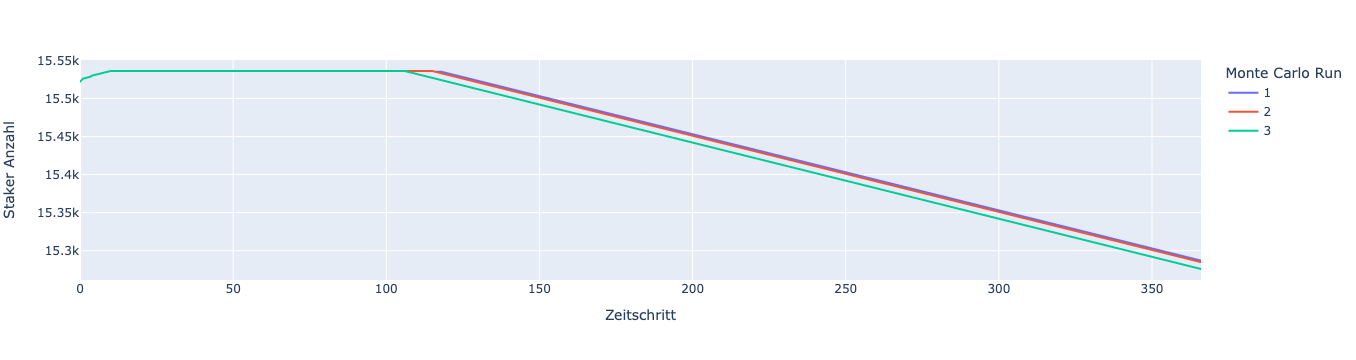

In [40]:
import plotly.express as px

# Zusammenführen der Daten der Monte Carlo Runs
combined_df = pd.concat([
    Monte_Carlo_Run_1_processed.assign(run=1),
    Monte_Carlo_Run_2_processed.assign(run=2),
    Monte_Carlo_Run_3_processed.assign(run=3)
])

# Sicherstellen, dass der Datentyp für die 'run' Spalte korrekt ist
combined_df['run'] = combined_df['run'].astype(str)

# Erstellen des Plots ohne Facetten
fig = px.line(combined_df, x='timestep', y='Staker_Anzahl', color='run', height=500, labels={'run': 'Monte Carlo Run', 'Staker_Anzahl': 'Staker Anzahl', 'timestep': 'Zeitschritt'})

# Plot anzeigen
fig.show()


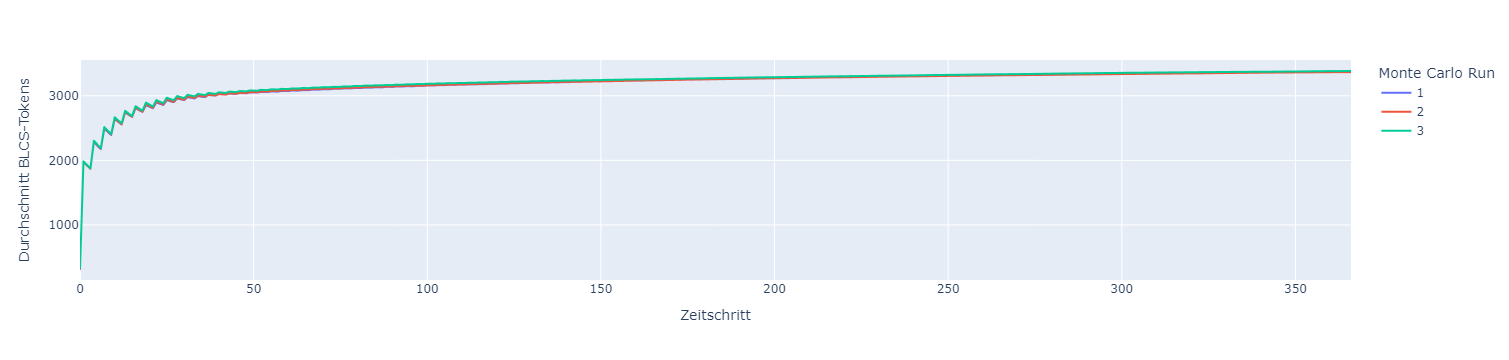

In [41]:
# Zusammenführen der Daten der Monte Carlo Runs
combined_stakers_df = pd.concat([
    Monte_Carlo_Run_1_filtered_stakers.assign(run=1),
    Monte_Carlo_Run_2_filtered_stakers.assign(run=2),
    Monte_Carlo_Run_3_filtered_stakers.assign(run=3)
])

# Sicherstellen, dass der Datentyp für die 'run' Spalte korrekt ist
combined_stakers_df['run'] = combined_stakers_df['run'].astype(str)

# Erstellen des Plots für den Durchschnitt der BLCS-Tokens
fig = px.line(combined_stakers_df, x='timestep', y='avg_blcs_tokens', color='run', height=500, labels={'run': 'Monte Carlo Run', 'avg_blcs_tokens': 'Durchschnitt BLCS-Tokens', 'timestep': 'Zeitschritt'})

# Plot anzeigen
fig.show()


# 9.4 [combined_df_stakers] Staker: Rewards über die Zeit, Rückerstattung und Differenz

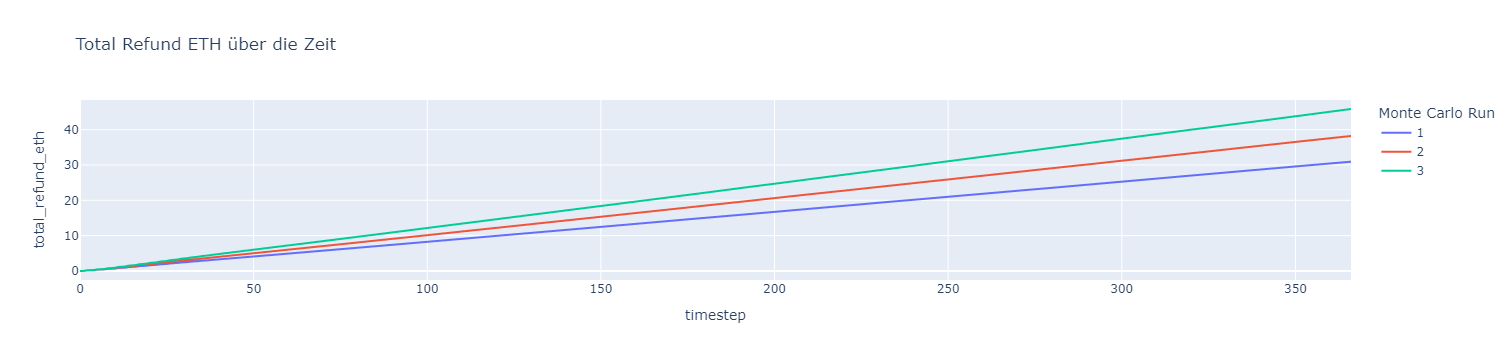

In [42]:
combined_df_stakers = pd.concat([
    Monte_Carlo_Run_1_filtered_stakers.assign(run=1),
    Monte_Carlo_Run_2_filtered_stakers.assign(run=2),
    Monte_Carlo_Run_3_filtered_stakers.assign(run=3)
])
# Erstellen des Plots für total_refund_eth
fig_total_refund_eth = px.line(combined_df_stakers, x='timestep', y='total_refund_eth', color='run', labels={'run': 'Monte Carlo Run'}, title='Total Refund ETH über die Zeit')

# Erstellen des Plots für total_rewards_since_start
fig_total_rewards_since_start = px.line(combined_df_stakers, x='timestep', y='total_rewards_since_start', color='run', labels={'run': 'Monte Carlo Run'}, title='Total Rewards Since Start über die Zeit')

# Erstellen des Plots für difference
fig_difference = px.line(combined_df_stakers, x='timestep', y='difference', color='run', labels={'run': 'Monte Carlo Run'}, title='Difference über die Zeit')

# Anzeigen der Plots
fig_total_refund_eth.show()
fig_total_rewards_since_start.show()
fig_difference.show()


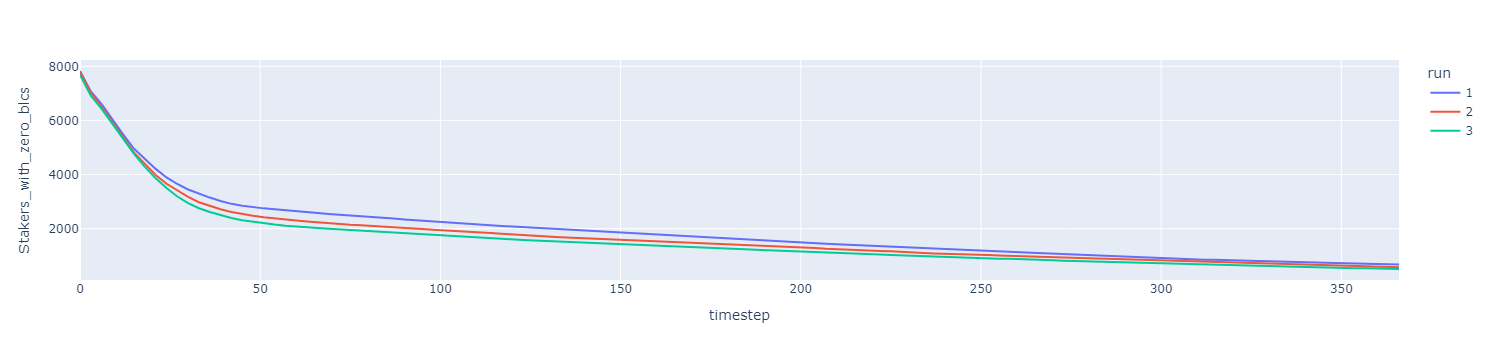

In [43]:
# Funktion zur Berechnung der Anzahl der Staker mit 0 BLCS-Tokens
def count_stakers_with_zero_blcs(stakers):
    return sum(1 for staker in stakers if staker['blcs_tokens'] == 0)

# Filterung der DataFrame, um nur jede dritte Zeile anzuzeigen
def filter_and_count_zero_blcs(df):
    filtered_df = df.iloc[::3].copy()
    filtered_df['Stakers_with_zero_blcs'] = filtered_df['Stakers'].apply(count_stakers_with_zero_blcs)
    return filtered_df

# Anwendung der Funktion auf die Monte_Carlo_Run DataFrames
Monte_Carlo_Run_1_processed_zero_count = filter_and_count_zero_blcs(Monte_Carlo_Run_1_processed_new)
Monte_Carlo_Run_2_processed_zero_count = filter_and_count_zero_blcs(Monte_Carlo_Run_2_processed_new)
Monte_Carlo_Run_3_processed_zero_count = filter_and_count_zero_blcs(Monte_Carlo_Run_3_processed_new)

# Zusammenführen der Daten
combined_df_sum = pd.concat([
    Monte_Carlo_Run_1_processed_zero_count.assign(run=1),
    Monte_Carlo_Run_2_processed_zero_count.assign(run=2),
    Monte_Carlo_Run_3_processed_zero_count.assign(run=3)
])

# Nur die Spalten 'timestep' und 'Stakers_with_zero_blcs' anzeigen
combined_df_sum_filtered = combined_df_sum[['timestep', 'Stakers_with_zero_blcs', 'run']]

fig = px.line(combined_df_sum_filtered, x='timestep', y='Stakers_with_zero_blcs', color='run')
fig.show()

# 9.5 verbesserte Einnahmen Darstellung mit Refund

In [44]:
# Funktion zur Erstellung eines Diagramms für einen einzelnen Monte-Carlo-Run
def create_monte_carlo_plot(run_df, run_number):
    fig = px.line(run_df, x='timestep', y=['Einnahmen_Euro', 'Ausgaben', 'total_refund_dollar', 'Differenz', 'Neue_Differenz'],
                  labels={'value': 'Wert', 'variable': 'Parameter'}, title=f'Monte Carlo Run {run_number} - Einnahmen, Ausgaben, Refund und Differenz')
    fig.show()

# Diagramme für die einzelnen Monte-Carlo-Runs erstellen
create_monte_carlo_plot(Monte_Carlo_Run_1_processed_new, 1)
create_monte_carlo_plot(Monte_Carlo_Run_2_processed_new, 2)
create_monte_carlo_plot(Monte_Carlo_Run_3_processed_new, 3)
